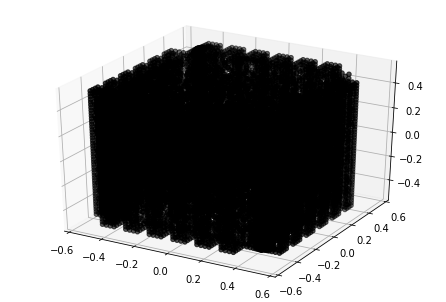

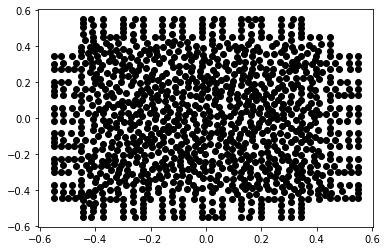

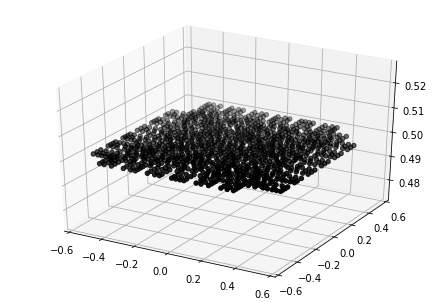

Real 2D (Dxy = -Dyx = 0)


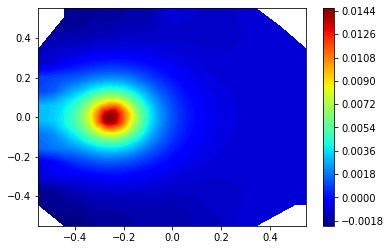

Real 2D (Dxy = -Dyx = 2)


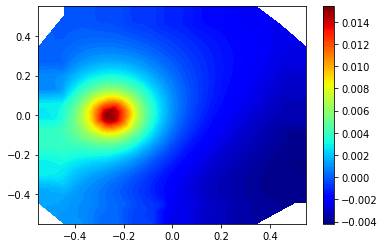

Imaginary 2D (Dxy = -Dyx = 0)


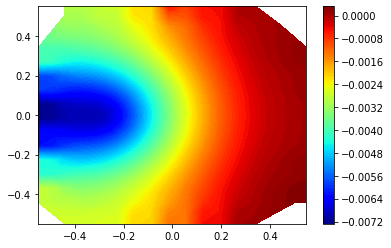

Imaginary 2D (Dxy = -Dyx = 2)


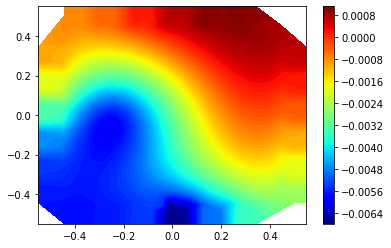

Phase Plot (Dxy = -Dyx = 0)


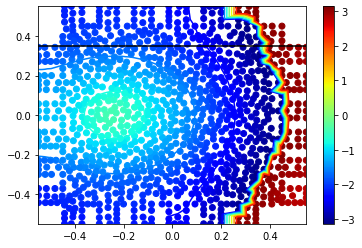

Phase Plot (Dxy = -Dyx = 2)


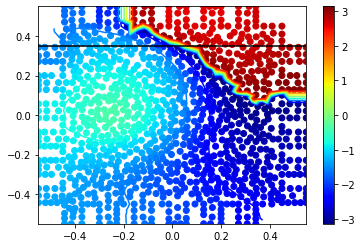

Unwrapped Phase Plot (Dxy = -Dyx = 0)


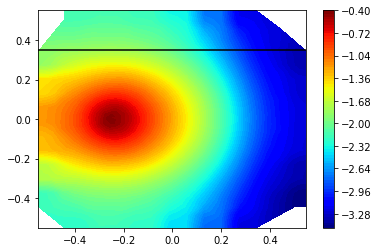

Unwrapped Phase Plot (Dxy = -Dyx = 2)


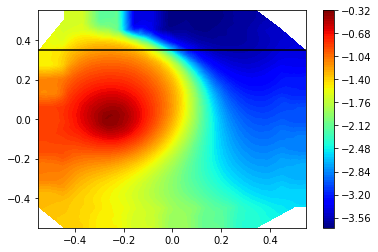

Line Phase Plots


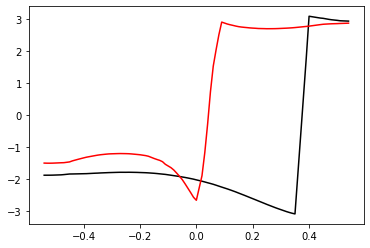

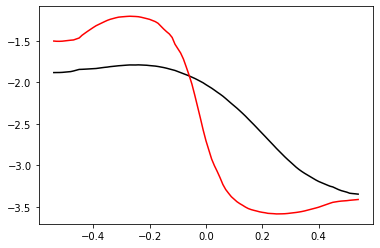

In [10]:
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase
import timeit
from matplotlib.tri import Triangulation
from scipy import interpolate

def solver(g, tol, mesh, omega, alpha, W, Dxy, Dxx, Dyy):
   
    #(ureal, uimag, sigma, mu) = TrialFunctions(W)
    #(v1, v2, v3, v4) = TestFunctions(W)
    (ureal, uimag) = TrialFunctions(W)
    (v1, v2) = TestFunctions(W)

    #a = (dot(grad(uimag),grad(v1)) + omega/alpha*ureal*v1 + omega/alpha*uimag*v2 - dot(grad(ureal),grad(v2)) + sigma*v3 + dot(grad(ureal), grad(v3)) + mu*v4 + dot(grad(uimag), grad(v4)))*dx
    #a = (dot(grad(uimag),grad(v1)) + omega/alpha*ureal*v1 + omega/alpha*uimag*v2 - dot(grad(ureal),grad(v2)))*dx
    a = (alpha*dot(grad(uimag),grad(v1)) + omega*ureal*v1 + omega*uimag*v2 - alpha*dot(grad(ureal),grad(v2)))*dx + (Dxy/np.sqrt(Dxx*Dyy)*alpha*uimag.dx(1)*v1.dx(0) - Dxy/np.sqrt(Dxx*Dyy)*alpha*uimag.dx(0)*v1.dx(1) - Dxy/np.sqrt(Dxx*Dyy)*alpha*ureal.dx(1)*v2.dx(0) + Dxy/np.sqrt(Dxx*Dyy)*alpha*ureal.dx(0)*v2.dx(1))*dx

    #L =  - g/alpha*v2*dx
    L =  - g*v2*dx
   
    def bot(x, on_boundary): return on_boundary and near(x[2], 0, tol)
    noslip = Constant(0.0)
    bc0 = DirichletBC(W.sub(0), noslip, bot)
    bc1 = DirichletBC(W.sub(1), noslip, bot)
    G = Expression('0', degree = 0)
    def boundary(x, on_boundary):
            return on_boundary and not near(x[2], 0, tol)   
    #bc2 = DirichletBC(W.sub(2), G, boundary)
    #bc3 = DirichletBC(W.sub(3), G, boundary)
    bcs = [bc0, bc1]

    w = Function(W)
    solve(a == L, w, bcs, solver_parameters={'linear_solver':'mumps'})
   
    (ureal, uimag) = w.split()
   
    return ureal, uimag

def scatter3d(xdata,ydata,zdata, udata, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(udata), vmax=max(udata))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(xdata, ydata, zdata, c=scalarMap.to_rgba(udata))
    scalarMap.set_array(udata)
    fig.colorbar(scalarMap)
    plt.show()
    
def scatter3dCoords(shapeMat):
    xdata = shapeMat[:,0]
    xdata = np.transpose(xdata)
    ydata = shapeMat[:,1]
    ydata = np.transpose(ydata)
    zdata = shapeMat[:,2]
    zdata = np.transpose(zdata)
    
    oneM = np.ones(np.shape(shapeMat))
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(xdata, ydata, zdata, c='black')
    plt.show()
    
def find_closest_vertex(x, y, px, py, edges):
    xedges0 = px[edges[:, 0]]
    yedges0 = py[edges[:, 0]]
    xedges1 = px[edges[:, 1]]
    yedges1 = py[edges[:, 1]]
    d0 = dist(x, y, xedges0, yedges0)
    d1 = dist(x, y, xedges1, yedges1)
    minD0 = min(d0)
    minD1 = min(d1)
    if (minD0 < minD1):
        ind = np.where(d0 == minD0)[0]
        vertInd = edges[ind, 0]
    else:
        ind = np.where(d1 == minD1)[0]
        vertInd = edges[ind, 1]
    return vertInd
    
def find_verts(vertIndex, edgeList):
    hasVertex = (edgeList[:, 0] == vertIndex)
    otherV = edgeList[hasVertex, 1]
    hasVertex2 = (edgeList[:, 1] == vertIndex)
    otherV = np.append(otherV, edgeList[hasVertex2, 0])
    hasVertex = hasVertex + hasVertex2
    searchVerts = edgeList[hasVertex]
    remainVerts = edgeList[~hasVertex]
    return otherV, searchVerts, remainVerts

def tri_unwrap(phase, x_st, y_st, x_coord, y_coord, triang):
    edges = triang.edges
    startIndex = find_closest_vertex(x_st, y_st, x_coord, y_coord, edges)
    startIndex = startIndex[0]
    VtoLook, sVs, rVs = find_verts(startIndex, edges)
    
    look = True
    while(look):
        indLook = VtoLook[0]
        VtoLook = VtoLook[1:]
        newVs, tempsVs, rVs = find_verts(indLook, rVs)
        sVs = np.vstack((sVs, tempsVs))
        VtoLook = np.hstack((VtoLook, newVs))
        if(len(rVs) == 0):
            look = False
            
    #hasOffset = [False]*len(projx)
    #Offsets = np.zeros(len(projx))
    hasOffset = [False]*len(x_coord)
    Offsets = np.zeros(len(y_coord))
    hasOffset[startIndex] = True
    for i in range(0, len(sVs)):
        if(hasOffset[sVs[i, 0]] == False):
            newPt = sVs[i, 0]
            oldPt = sVs[i, 1]
            Offsets[newPt] = Offsets[oldPt]
            diff = phase[newPt] - phase[oldPt]
            if((diff - 2*np.pi)**2 < (diff**2)):
                Offsets[newPt] -= 2*np.pi
            if((diff + 2*np.pi)**2 < (diff**2)):
                Offsets[newPt] += 2*np.pi
            hasOffset[newPt] = True
        if(hasOffset[sVs[i, 1]] == False):
            newPt = sVs[i, 1]
            oldPt = sVs[i, 0]
            Offsets[newPt] = Offsets[oldPt]
            diff = phase[newPt] - phase[oldPt]
            if((diff - 2*np.pi)**2 < (diff**2)):
                Offsets[newPt] -= 2*np.pi
            if((diff + 2*np.pi)**2 < (diff**2)):
                Offsets[newPt] += 2*np.pi
            hasOffset[newPt] = True
    return (phase + Offsets)

def dist(x0, y0, xd, yd):
    return np.sqrt((x0 - xd)**2 + (y0 - yd)**2)

def proj_2d(xdata, ydata, fdist):
    minDX = fdist*(np.max(xdata) - np.min(xdata))
    minDY = fdist*(np.max(ydata) - np.min(ydata))
    minD = min([minDX, minDY])
    j = 0
    look = True
    xd = xdata
    yd = ydata
    while(look):
        keepList = (dist(xd[j], yd[j], xd, yd) > minD)
        keepList[j] = True
        xd = xd[keepList]
        yd = yd[keepList]
        j += 1
        if(j >= len(xd)):
            look = False
    return xd, yd

def top_surface(xdata, ydata, zdata, projx, projy, fdist, rat):
    top_s = np.zeros(len(projx))
    minDX = fdist*(np.max(xdata) - np.min(xdata))
    minDY = fdist*(np.max(ydata) - np.min(ydata))
    minD = min([minDX, minDY])
    minD = minD*rat
    for i in range(0, len(projx)):
        lookList = (dist(projx[i], projy[i], xdata, ydata) < minD)
        if(len(zdata[lookList]) > 0):
            top_s[i] = np.max(zdata[lookList])
    return(top_s)

def projFunction2d(ur, ui, px, py, tz, depth, layers):
    ur2d = np.zeros(len(px))
    ui2d = np.zeros(len(px))
    weightSum = np.zeros(len(px))
    Rsheet = np.zeros(len(px))
    Isheet = np.zeros(len(px))
    for i in range(0, layers):
        for j in range(0, len(px)):
            Rsheet[j] = ur(px[j], py[j], tz[j]*(1 - i/layers))
            Isheet[j] = ui(px[j], py[j], tz[j]*(1 - i/layers))
        wtemp = np.exp(-(tz*i)/(depth*layers))
        weightSum += wtemp
        ur2d += wtemp*Rsheet
        ui2d += wtemp*Isheet
    ur2d = ur2d/weightSum
    ui2d = ui2d/weightSum
    return ur2d, ui2d

def projFunctionLine(ur, ui, px, py, tz, depth, layers, Dx, Dy, Dz):
    ur2d = np.zeros(len(px))
    ui2d = np.zeros(len(px))
    weightSum = np.zeros(len(px))
    Rsheet = np.zeros(len(px))
    Isheet = np.zeros(len(px))
    px = px/np.sqrt(Dx)
    py = py/np.sqrt(Dy)
    tz = tz/np.sqrt(Dz)
    for i in range(0, layers):
        for j in range(0, len(px)):
            Rsheet[j] = ur(px[j], py[j], tz[j]*(1 - i/layers))
            Isheet[j] = ui(px[j], py[j], tz[j]*(1 - i/layers))
        wtemp = np.exp(-(tz*i)/(depth*layers))
        weightSum += wtemp
        ur2d += wtemp*Rsheet
        ui2d += wtemp*Isheet
    ur2d = ur2d/weightSum
    ui2d = ui2d/weightSum
    return ur2d, ui2d

def phase_line(xc, yc, xs, ys, theta, step, EOBTol):
    xList = [xc]
    yList = [yc]
    rightXList = []
    rightYList = []
    xtemp = xc
    ytemp = yc
    lookRight = True
    while(lookRight):
        xtemp += step*np.cos(theta)
        ytemp += step*np.sin(theta)
        if(min(dist(xtemp, ytemp, xs, ys)) > EOBTol):
            lookRight = False
            toPop = int(np.floor(EOBTol/step))
            rightXList = rightXList[:-toPop]
            rightYList = rightYList[:-toPop]
        else:
            rightXList.append(xtemp)
            rightYList.append(ytemp)
    leftXList = []
    leftYList = []
    xtemp = xc
    ytemp = yc
    lookLeft = True
    while(lookLeft):
        xtemp -= step*np.cos(theta)
        ytemp -= step*np.sin(theta)
        if(min(dist(xtemp, ytemp, xs, ys)) > EOBTol):
            lookLeft = False
            toPop = int(np.floor(EOBTol/step))
            leftXList = leftXList[:-toPop]
            leftYList = leftYList[:-toPop]
        else:
            leftXList.append(xtemp)
            leftYList.append(ytemp)
    leftXList = list(reversed(leftXList))
    leftYList = list(reversed(leftYList))
    xList = leftXList + xList + rightXList
    yList = leftYList + yList + rightYList
    return np.array(xList), np.array(yList)

def fullSim(mesh, omega, Dxy, Dx, Dy, Dz, depth, truexc, trueyc, ktrue, fd, rat):
    #Rescale mesh geometry
    meshpts = mesh.coordinates()
    meshpts[:, 0] *= 1.0/np.sqrt(Dx)
    meshpts[:, 1] *= 1.0/np.sqrt(Dy)
    meshpts[:, 2] *= 1.0/np.sqrt(Dz)
    xdata = meshpts[:, 0]
    ydata = meshpts[:, 1]
    zdata = meshpts[:, 2]
    xcenter = truexc/np.sqrt(Dx)
    ycenter = trueyc/np.sqrt(Dy)
    
    projx, projy = proj_2d(xdata, ydata, fd)
    topS = top_surface(xdata, ydata, zdata, projx, projy, fd, rat)
    
    #Number of z-layers for phase conversion
    layers = math.ceil(len(zdata)/len(projx))

    minD = min(dist(xcenter, ycenter, projx, projy))
    index = [i for i, j in enumerate(dist(xcenter, ycenter, projx, projy)) if j == minD][0]
    zspot = topS[index]
    
    #Define test functions on mesh
    CG1_elem = FiniteElement("CG", mesh.ufl_cell(), 1)
    CG2_elem = FiniteElement("CG", mesh.ufl_cell(), 1)
    
    W_elem = MixedElement([CG1_elem, CG2_elem])
    W = FunctionSpace(mesh, W_elem)
    
    #Change this if you need defects
    qtot = Expression('1', degree = 2)
    alpha1 = qtot
    
    kx = ktrue*Dx
    ky = ktrue*Dy
    
    g = Expression('omega*exp(b*(x[2] - top) - kx*(x[0]-xcenter)*(x[0]-xcenter) - ky*(x[1]-ycenter)*(x[1]-ycenter))', degree = 2, kx = kx, ky = ky, b = 1*np.sqrt(Dz), top = zspot, xcenter = xcenter, ycenter = ycenter, omega = omega)

    tol = 1E-14
    ureal, uimag = solver(g, tol, mesh, omega, alpha1, W, Dxy, Dx, Dy)
        
    ureal.set_allow_extrapolation(True)
    uimag.set_allow_extrapolation(True)
   
    projR, projI = projFunction2d(ureal, uimag, projx,
                                  projy, topS, depth, 3*layers)
    meshpts[:, 0] *= np.sqrt(Dx)
    meshpts[:, 1] *= np.sqrt(Dy)
    meshpts[:, 2] *= np.sqrt(Dz)
    return ureal, uimag, projR, projI, projx*np.sqrt(Dx), projy*np.sqrt(Dy), topS*np.sqrt(Dz)

def makeTri(projx, projy, max_l):
    tri = Triangulation(projx, projy)
    triangles = tri.triangles
    # Mask off unwanted triangles.
    xtri = projx[triangles] - np.roll(projx[triangles], 1, axis=1)
    ytri = projy[triangles] - np.roll(projy[triangles], 1, axis=1)
    ds = np.sqrt(xtri**2 + ytri**2)
    maxi = np.max(ds, axis=1)
    tdist = np.mean(ds)
    tri.set_mask(maxi > max_l)
    return tri, tdist

def lineValues(xLine, yLine, projx, projy, phase, unwrap):
    coords = np.vstack((projx, projy)).T
    lphase = interpolate.LinearNDInterpolator(coords, phase, )
    Lphase = lphase((xLine, yLine))
    uphase = interpolate.LinearNDInterpolator(coords, unwrap, )
    Uphase = uphase((xLine, yLine))
    return Lphase, Uphase
    
# Define geometry
#box = Box(Point(0, 0, 0), Point(2, 1, 1))
#sphere = Sphere(Point(.25, .25, 1), 1)
#cylinder = Cylinder(Point(0, 0, -1), Point(0, 0, 1), 1.0, 0.5)
#box2 = Box(Point(0,0,0), Point(1, 2, 1.5))
#geometry = box + box2 + sphere
Rscale = .1
NumRs = 7
BoxScale = 1.0
bBox = Box(Point(-(BoxScale- Rscale)/2, -(BoxScale - Rscale)/2, -(BoxScale)/2), Point((BoxScale- Rscale)/2, (BoxScale - Rscale)/2, (BoxScale)/2))
geometry = bBox
wid = BoxScale/(2*NumRs)
for i in range(1, NumRs):
    xst = -BoxScale/2 - Rscale/2 + 2*wid*i
    xBox = Box(Point(xst - wid/2, -(BoxScale + Rscale)/2, -(BoxScale)/2), Point(xst + wid/2, (BoxScale + Rscale)/2, (BoxScale)/2))
    geometry += xBox
for i in range(1, NumRs):
    yst = -BoxScale/2 - Rscale/2 + 2*wid*i
    yBox = Box(Point(-(BoxScale + Rscale)/2, yst - wid/2, -(BoxScale)/2), Point((BoxScale + Rscale)/2, yst + wid/2, (BoxScale)/2))
    geometry += yBox

# Generate mesh
mesh = generate_mesh(geometry, 35)

# Frequency of measurement
omega = 20

# Diffusivity
Dx = 1
Dy = 1
Dz = 1
Dxy1 = 0.000001
Dxy2 = 2

# Penetration depth of the laser beam
depth = .5
# Center point of beam
truexc = -.25
trueyc = 0
#Beam width
ktrue = 1000

# Angle of slice and center
lX = truexc
lY = (BoxScale - Rscale)/2 - Rscale
#lY=trueyc
theta = 0

#Density of the 2d projection and max allowed length of a triangle
fd = .02
max_l = .2
rat = 2
step = .01

meshpts = mesh.coordinates()
xdata = meshpts[:, 0]
ydata = meshpts[:, 1]
zdata = meshpts[:, 2]



#Simulation Section

#Get the 3d simulation and projections into the 2d plane
ureal1, uimag1, projR1, projI1, projx1, projy1, topS1 = fullSim(mesh, omega, Dxy1, Dx, Dy, Dz, depth, truexc, trueyc, ktrue, fd, rat)
ureal2, uimag2, projR2, projI2, projx2, projy2, topS2 = fullSim(mesh, omega, Dxy2, Dx, Dy, Dz, depth, truexc, trueyc, ktrue, fd, rat)
#Make a triangulation of the 2d plane values
tri, tdist = makeTri(projx1, projy1, max_l)
#Make a line at angle theta emerging from truexc and trueyc
xLine, yLine = phase_line(lX, lY, projx1, projy1, theta, step, tdist)
#Find the phase of all points and unwrap it
phase1 = np.arctan2(projI1, projR1)
unwrap1 = tri_unwrap(phase1, truexc, trueyc, projx1, projy1, tri)
phase2 = np.arctan2(projI2, projR2)
unwrap2 = tri_unwrap(phase2, truexc, trueyc, projx1, projy1, tri)
#Find the phase along the specified line
Lphase1, Uphase1 = lineValues(xLine, yLine, projx1, projy1, phase1, unwrap1)
Lphase2, Uphase2 = lineValues(xLine, yLine, projx1, projy1, phase2, unwrap2)





#Plotting Section

scatter3dCoords(meshpts)
plt.show()

plt.scatter(projx1, projy1, c='black')
plt.show()

surfCoords = np.zeros((len(projx1), 3))
surfCoords[:, 0] = projx1
surfCoords[:, 1] = projy1
surfCoords[:, 2] = topS1

scatter3dCoords(surfCoords)
plt.show()

print('Real 2D (Dxy = -Dyx = 0)')

plt.figure()
plt.tricontourf(tri, projR1, 100, cmap = cmx.jet)
#plt.scatter(projx,projy, c=projR)

plt.colorbar()
plt.show()

print('Real 2D (Dxy = -Dyx = ' + str(Dxy2) + ')')

plt.figure()
plt.tricontourf(tri, projR2, 100, cmap = cmx.jet)
#plt.scatter(projx,projy, c=projR)

plt.colorbar()
plt.show()

print('Imaginary 2D (Dxy = -Dyx = 0)')

plt.figure()
plt.tricontourf(tri, projI1, 100, cmap = cmx.jet)
#plt.scatter(projx,projy, c=projI)
plt.colorbar()
plt.show()

print('Imaginary 2D (Dxy = -Dyx = ' + str(Dxy2) + ')')

plt.figure()
plt.tricontourf(tri, projI2, 100, cmap = cmx.jet)
#plt.scatter(projx,projy, c=projI)
plt.colorbar()
plt.show()


print('Phase Plot (Dxy = -Dyx = 0)')

plt.figure()
plt.tricontour(tri, phase1, cmap = cmx.jet)
plt.scatter(projx1,projy1, c=phase1, cmap = cmx.jet)
plt.plot(xLine, yLine, c='black')
plt.colorbar()
plt.show()

print('Phase Plot (Dxy = -Dyx = ' + str(Dxy2) + ')')

plt.figure()
plt.tricontour(tri, phase2, cmap = cmx.jet)
plt.scatter(projx1,projy1, c=phase2, cmap = cmx.jet)
plt.plot(xLine, yLine, c='black')
plt.colorbar()
plt.show()

print('Unwrapped Phase Plot (Dxy = -Dyx = 0)')

plt.figure()
plt.tricontourf(tri, unwrap1, 100, cmap = cmx.jet)
plt.plot(xLine, yLine, c='black')

plt.colorbar()
plt.show()

print('Unwrapped Phase Plot (Dxy = -Dyx = ' + str(Dxy2) + ')')

plt.figure()
plt.tricontourf(tri, unwrap2, 100, cmap = cmx.jet)
plt.plot(xLine, yLine, c='black')

plt.colorbar()
plt.show()

print('Line Phase Plots')

plt.plot(xLine/np.cos(theta), Lphase1, c='black')
plt.plot(xLine/np.cos(theta), Lphase2, c='red')
plt.show()

plt.plot(xLine/np.cos(theta), Uphase1, c='black')
plt.plot(xLine/np.cos(theta), Uphase2, c='red')

plt.show()

